In [1]:
import cv2
import matplotlib.pyplot as plt
import time 
import glob
from skimage.feature import hog, local_binary_pattern 
import numpy as np 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import joblib

import warnings 
warnings.filterwarnings('ignore')

In [2]:
pos_path = glob.glob('./pos/*')
neg_path = glob.glob('./neg/*')

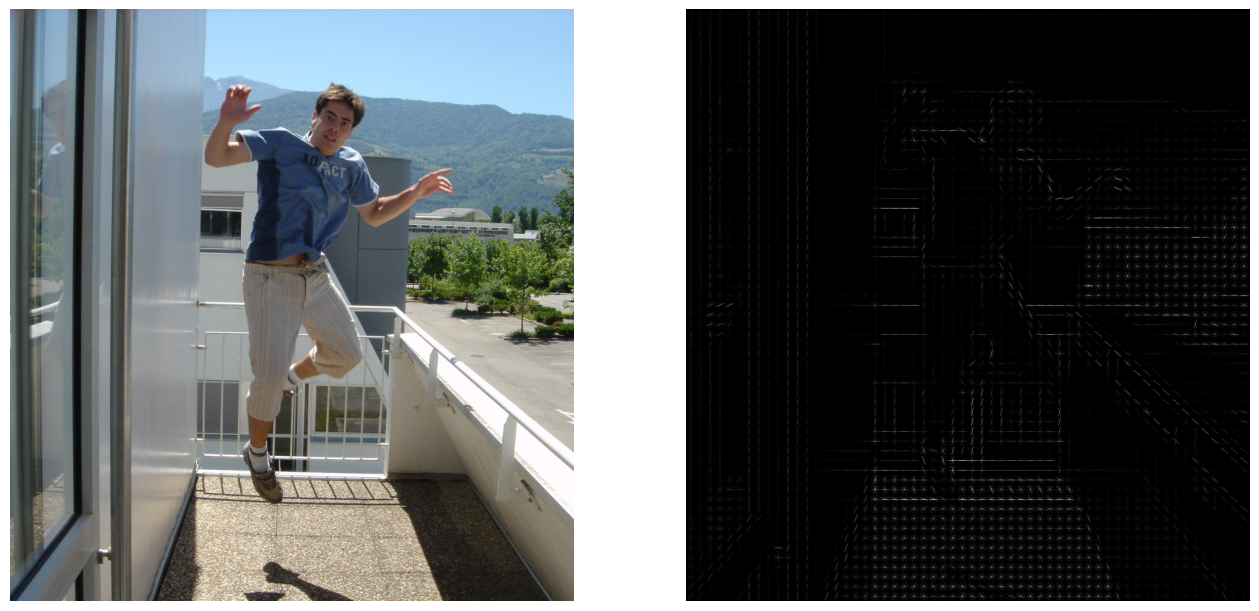

In [3]:
# HOG descriptor visualization
example_image = cv2.imread(pos_path[20])
img = cv2.cvtColor(example_image, cv2.COLOR_BGR2GRAY)

hog_features , visualized = hog(img, orientations = 9,pixels_per_cell= (16,16), cells_per_block= (2,2), visualize= True)
fig = plt.figure(figsize= (16,8))
fig.add_subplot(1,2,1)
plt.imshow(cv2.cvtColor(example_image,cv2.COLOR_BGR2RGB))
plt.axis('off')
fig.add_subplot(1,2,2)
plt.imshow(visualized, cmap ='gray')
plt.axis('off')
plt.show()

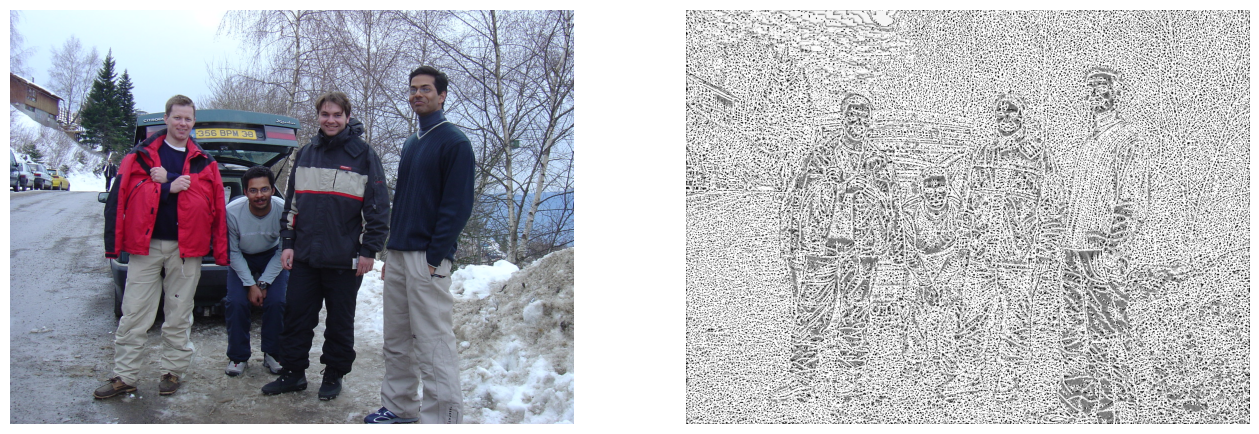

In [4]:
# local binary pattern descriptor visualization
 
ex_img = cv2.imread(pos_path[10])
imgs = cv2.cvtColor(ex_img, cv2.COLOR_BGR2GRAY)

radius = 3
n_points = 3*8
lbp_features = local_binary_pattern(imgs, n_points, radius, method ="uniform")

fig = plt.figure(figsize= (16,8))
fig.add_subplot(1,2,1)
plt.imshow(cv2.cvtColor(ex_img,cv2.COLOR_BGR2RGB))
plt.axis('off')
fig.add_subplot(1,2,2)
plt.imshow(lbp_features, cmap ='gray')
plt.axis('off')
plt.show()

In [5]:
num_pos_samples = len(pos_path)
print("The number of positive samples {}".format(num_pos_samples))
num_neg_samples = len(neg_path)
print("The number of negative samples {}".format(num_neg_samples))
pos_labels = np.ones(num_pos_samples)
neg_labels = np.zeros(num_neg_samples)

The number of positive samples 902
The number of negative samples 1218


In [6]:
label=[]
label = np.append(pos_labels , neg_labels)
label = label.astype('int')
label.shape

(2120,)

In [8]:
data =[]
eps =1e-7
start = time.time()
for path in pos_path:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgs = cv2.resize(img, (64, 128))
    im_hog = hog(imgs, orientations= 9, pixels_per_cell= (8,8), cells_per_block= (2,2), feature_vector= True)
    
    im_lbp = local_binary_pattern(imgs, n_points, radius, method ="uniform")
    (hist,_) = np.histogram(im_lbp.ravel(), bins = np.arange(0,n_points+3), range = (0,n_points+2))
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)
    c1 = np.hstack([im_hog, hist])
    data.append(c1)


for paths in neg_path:
    img = cv2.imread(paths)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgs = cv2.resize(img, (64, 128))
    img_hog = hog(imgs,orientations= 9, pixels_per_cell= (8,8), cells_per_block= (2,2), feature_vector= True)
    
    img_lbp = local_binary_pattern(imgs,n_points, radius, method = "uniform")
    (hist,_) = np.histogram(img_lbp.ravel(), bins = np.arange(0,n_points+3), range = (0,n_points+2))
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)
    c2 = np.hstack([img_hog, hist])
    data.append(c2)


data = np.asarray(data)
label = np.asarray(label)
totaltime = round(time.time() - start, 2)
print("Total time taken for reading and extracting hog and lbp features {} seconds".format(totaltime))

Total time taken for reading and extracting hog and lbp features 52.05 seconds


In [9]:
# splitting our dataset into train and test
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size= 0.2, random_state= 42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1696, 3806) (1696,)
(424, 3806) (424,)


In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler

In [11]:
# Creating Object
scaler = StandardScaler()  
# Standardizing the features
x_train = scaler.fit_transform(x_train)  
x_test = scaler.transform(x_test)

In [ ]:
np.random.seed(1234)

In [12]:
# Building svm classifier
param_grid = {'C': [0.1,1,10,100,1000],
              'gamma': [1,0.1,0.01,0.001,0.0001],
              'kernel': ['rbf']
              }

model = GridSearchCV(SVC(), param_grid, cv = 5, refit= True, verbose= 3)
model.fit(x_train, y_train)
print(model.best_estimator_.get_params())
# save trained model
print("Model saved to", joblib.dump(model, "model_svm.pkl"))
y_pred = model.predict(x_test)
print("Accuracy of model is {}".format(accuracy_score(y_test, y_pred)))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.576 total time=   6.7s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.575 total time=   6.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.575 total time=   6.7s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.575 total time=   5.7s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.575 total time=   6.5s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.576 total time=   6.7s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.575 total time=   5.6s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.575 total time=   5.5s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.575 total time=   5.5s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.575 total time=   5.6s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.576 total time=   6.4s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       242
           1       0.84      0.86      0.85       182

    accuracy                           0.87       424
   macro avg       0.87      0.87      0.87       424
weighted avg       0.87      0.87      0.87       424



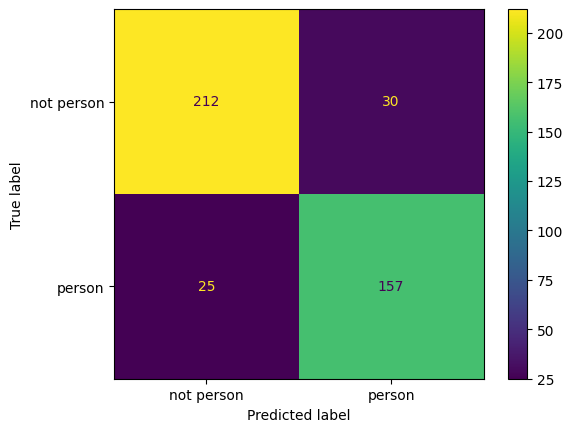

In [14]:
cm = confusion_matrix(y_test, y_pred) 
cm_display = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= ['not person', 'person'])
cm_display.plot()
plt.show()

Sliding window plays an important role in object detection, as they allows us to known where the object resides in the image

In [15]:
def sliding_window(image, step_size,  window_size):
    for y in range(0, image.shape[0] , step_size):
        for x in range(0, image.shape[1],step_size):
            yield(x,y,image[y:y+window_size[1],x:x+window_size[0]])

In [16]:
from skimage.transform import pyramid_gaussian

In [26]:
imge = cv2.imread('test_img.jpeg')

image = cv2.cvtColor(imge, cv2.COLOR_BGR2GRAY)
print(image.shape)
cv2.imshow('image',image)
cv2.waitKey(0)
cv2.destroyAllWindows()

(540, 960)


In [18]:
# Load the saved model 
model = joblib.load("model_svm.pkl")

In [27]:
window_size = (64, 128)
scale = 0
downscale = 1.05
threshold = 0.3
detections = []

for im_resized in pyramid_gaussian(image, downscale =  downscale):
    if im_resized.shape[0]< window_size[1] or im_resized.shape[1]< window_size[0]:
            break
    for (x,y,window) in sliding_window(im_resized, step_size = 8, window_size= window_size):
        if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
            continue
        fds = hog(window, orientations= 9, pixels_per_cell= (8,8), cells_per_block= (2,2)) #, block_norm= 'L2-Hys')
        fds1 = local_binary_pattern(window, n_points, radius, method = 'uniform')
        (hist,_) = np.histogram(fds1.ravel(), bins = np.arange(0,n_points+3), range = (0,n_points+2))
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        feat = np.hstack([fds, hist])

        feat = feat.reshape(1,-1)
        feat = scaler.transform(feat)
        pred = model.predict(feat)

        if pred == 1:
           if model.decision_function(scaler.inverse_transform(feat)) > 0.6:
               print("Decision:: Location -> ({}, {})".format(x,y))
               print("confidence score {}".format(model.decision_function(scaler.inverse_transform(feat))))
               detections.append((int(x*(downscale**scale)),int(y*(downscale**scale)),model.decision_function(scaler.inverse_transform(feat)),
                                  int(window_size[0]*(downscale**scale)),int(window_size[1]*(downscale**scale))))
    scale+= 1

Decision:: Location -> (216, 0)
confidence score [0.7669662]
Decision:: Location -> (416, 0)
confidence score [0.7747044]
Decision:: Location -> (424, 0)
confidence score [0.78600576]
Decision:: Location -> (496, 0)
confidence score [0.77554976]
Decision:: Location -> (504, 0)
confidence score [0.78970474]
Decision:: Location -> (576, 0)
confidence score [0.77165529]
Decision:: Location -> (752, 0)
confidence score [0.76400596]
Decision:: Location -> (816, 0)
confidence score [0.76925127]
Decision:: Location -> (848, 0)
confidence score [0.84194397]
Decision:: Location -> (856, 0)
confidence score [0.83626861]
Decision:: Location -> (864, 0)
confidence score [0.83152084]
Decision:: Location -> (872, 0)
confidence score [0.82220741]
Decision:: Location -> (880, 0)
confidence score [0.80398409]
Decision:: Location -> (224, 8)
confidence score [0.81316991]
Decision:: Location -> (232, 8)
confidence score [0.76904889]
Decision:: Location -> (296, 8)
confidence score [0.76239311]
Decision::

In [20]:
#for (x_1, y_1, _, w, h) in detections:
#    cv2.rectangle(image, (x_1,y_1),(x_1 + w, y_1 + h), (0, 0, 255), thickness =2)
#cv2.imshow(" Detections before NMS", imge.copy())
#cv2.waitKey(0)
#cv2.destroyAllWindows()


In [21]:
from imutils.object_detection import non_max_suppression

In [28]:
boxes = np.array([[x, y, x+w, y+h] for (x, y, _, w, h) in detections])
confsc = [score[0] for (x,y, score, w, h) in detections] 
confsc = np.array(confsc)
final_boxs = non_max_suppression(boxes = boxes, probs = confsc, overlapThresh= 0.3)
for (x1, y1, x2, y2) in final_boxs:
    cv2.rectangle(imge, (x1,y1), (x2, y2), (0,255,0),2)
cv2.imshow('peron detected',imge)
cv2.waitKey(0)
cv2.destroyAllWindows()
